<a href="https://colab.research.google.com/github/IamArmanNikkhah/DataMining-Absenteeism_at_Work/blob/main/DataMining_Ex4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
import math

**Cloning required files**

In [ ]:
!git clone https://github.com/IamArmanNikkhah/DataMining-Preprocess-Absenteeism_at_Work.git

**Load CSV file**

In [ ]:
df = pd.read_csv('/content/DataMining-Preprocess-Absenteeism_at_Work/Absenteeism_at_work.csv')

# Data Pre-processing

# Data cleaning

**Finding empty cells  in each row**

In [ ]:
def empty_cells(df):
    """
    Returns a list of columns with empty cells and the number of them
    """
    empty_cells = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            empty_cells.append((col, df[col].isnull().sum()))
    return empty_cells

empty_cells(df)

[('Reason for absence', 3),
 ('Month of absence', 1),
 ('Transportation expense', 7),
 ('Distance from Residence to Work', 3),
 ('Service time', 3),
 ('Age', 3),
 ('Work load Average/day', 10),
 ('Hit target', 6),
 ('Disciplinary failure', 6),
 ('Education', 10),
 ('Son', 6),
 ('Social drinker', 3),
 ('Social smoker', 4),
 ('Pet', 2),
 ('Weight', 1),
 ('Height', 14),
 ('Body mass index', 31),
 ('Absenteeism time in hours', 22)]

**Remove rows that have empty cells in "Absenteeism time in hours" column**

In [ ]:
def drop_empty_rows(df, column):
    return df.dropna(subset=[column])
df = drop_empty_rows(df, 'Absenteeism time in hours')

**Calculating null BMI values (if applicable)**


In [ ]:
# find empty cells in the BMI column
empty_cell = df['Body mass index'].isnull()

# calculate BMI according to Weight and Height columns if applicable
df.loc[empty_cell, 'Body mass index'] = df.loc[empty_cell, 'Weight'] / (df.loc[empty_cell, 'Height']/100)**2

# check if there are still empty cells in the BMI column
df['Body mass index'].isnull().sum()


2

In [ ]:
df[df['Body mass index'].isnull()]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
272,11,19.0,9.0,4,1,289.0,36.0,13.0,33.0,"294,217",...,0.0,1.0,2.0,1.0,NaN,1.0,90.0,NaN,NaN,24.0
273,5,0.0,9.0,5,1,235.0,20.0,13.0,43.0,"294,217",...,1.0,1.0,1.0,1.0,0.0,0.0,106.0,NaN,NaN,0.0


**Delete rows that their BMI can't be calculated**


In [ ]:
df = df.dropna(subset=['Body mass index'])

**converting 'Work load Average/day' data cells from string to integer**

In [ ]:
def convert_to_int(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: float(str(x).replace(',', '')))
    return df
df = convert_to_int(df, 'Work load Average/day')

**Filling empty cells in "Transportation expense" , "Distance from Residence to Work", "Service time", "Age", "Work load Average/day", "HIT target", "Son", "Pet" , "Weight" with mean**

In [ ]:
empty_cells(df)

[('Reason for absence', 3),
 ('Month of absence', 1),
 ('Transportation expense', 6),
 ('Distance from Residence to Work', 3),
 ('Service time', 3),
 ('Age', 2),
 ('Work load Average/day', 8),
 ('Hit target', 6),
 ('Disciplinary failure', 5),
 ('Education', 10),
 ('Son', 6),
 ('Social drinker', 3),
 ('Social smoker', 3),
 ('Pet', 2),
 ('Weight', 1),
 ('Height', 12)]

In [ ]:
def fillna_mean(df, column_name):
    """
    Get a column from a dataframe and fill empty rows with the average of that column
    """
    column = df[column_name]
    df[column_name] = column.fillna(column.mean())
    return df

def fill_null_with_normal_distribution(df, column_name):
    """
    Fill null cells in a column with normal distribution
    """
    mean = df[column_name].mean()
    std = df[column_name].std()
    null_count = df[column_name].isnull().sum()
    random_list = np.random.randn(null_count)
    random_list = random_list * std + mean
    random_list = random_list.round().astype(int)
    df.loc[df[column_name].isnull(), column_name] = random_list
    return df

def fill_null(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].skew() > 0.65 or df[col].skew() < -0.65:
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mean(), inplace=True)
    return df

df = fill_null(df)

**Finding outliners and noises in data and removing them**

In [ ]:
def find_outliners(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

Absenteeism_outliners   = find_outliners(df, 'Absenteeism time in hours')
df.drop(Absenteeism_outliners.index.tolist(),  inplace=True)

load_outliners          = find_outliners(df, 'Work load Average/day')
df.drop(load_outliners.index.tolist(),         inplace=True)

Service_outliners       = find_outliners(df, 'Service time')
df.drop(Service_outliners.index.tolist(),      inplace=True)

Age_outliners           = find_outliners(df, 'Age')
df.drop(Age_outliners.index.tolist(),          inplace=True)

Transportation_outliners= find_outliners(df, 'Transportation expense')
df.drop(Transportation_outliners.index.tolist(),  inplace=True)

Distance_outliners= find_outliners(df, 'Distance from Residence to Work')
df.drop(Distance_outliners.index.tolist(),  inplace=True)

Hit_outliners= find_outliners(df, 'Hit target')
df.drop(Hit_outliners.index.tolist(),  inplace=True)

Son_outliners= find_outliners(df, 'Son')
df.drop(Son_outliners.index.tolist(),  inplace=True)

Height_outliners= find_outliners(df, 'Height')
df.drop(Height_outliners.index.tolist(),  inplace=True)

**Finding a list of columns that are highly correlated to each other.**

In [ ]:
def highly_correlated(df, threshold=0.8):
    """
    Returns a list of columns that are highly correlated to each other.
    """
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

highly_correlated(df, 0.8)

['Body mass index']

According to the correlation matrix Weight and BMI are highly coorelated so we can ommit Weight column

In [ ]:
df.drop('Weight', axis=1, inplace=True)

**Removing least coorelated columns with the 'Absenteeism time in hours' column**

In [ ]:
def least_correlated(df, col):
    corr_matrix = df.corr().abs()
    corr_col = corr_matrix[col].sort_values(ascending=True)
    return corr_col[:5]

least_correlated(df, 'Absenteeism time in hours')

Education                          0.001619
Hit target                         0.003810
Pet                                0.008257
Distance from Residence to Work    0.010023
Service time                       0.010696
Name: Absenteeism time in hours, dtype: float64

Least coorelated columns have really low coorelation with the target, so we can remove them

In [ ]:
def remove_columns(df, col_list):
    df.drop(col_list, axis=1, inplace=True)
    return df

not_coorelated_columns =  least_correlated(df, 'Absenteeism time in hours').axes[0]
not_coorelated_columns =  [not_coorelated_columns[i] for i in range(3)]
df                     =  remove_columns(df, not_coorelated_columns)

**Remove noises using binnig method**

In [ ]:
def binning(df, col, bins, labels):
    """
    This function takes a dataframe, a column name, bins and labels as input.
    It returns a dataframe with the binned column.
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels)
    return df


In [ ]:
def get_stats(data, col):
    mean = data[col].mean()
    max = data[col].max()
    min = data[col].min()
    median = data[col].median()
    std = data[col].std()
    return mean, max, min, median, std

Son :

mean = 1.0673267326732674, max = 4.0, min = 0.0, median = 1.0, std = 1.1423580554117456


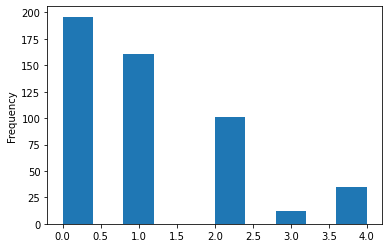

In [ ]:
mean, max, min, median, std = get_stats(df, 'Son')
print(f'mean = {mean}, max = {max}, min = {min}, median = {median}, std = {std}')
df['Son'].plot(kind='hist')

In [ ]:
df = binning(df, 'Son' , bins=[-1,0,2.5,4], labels=['no child', 'low child','high child' ])

Age:

mean = 35.53861386138614, max = 53.0, min = 27.0, median = 37.0, std = 5.308628987375284


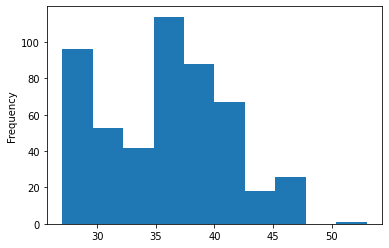

In [ ]:
mean, max, min, median, std = get_stats(df, 'Age')
print(f'mean = {mean}, max = {max}, min = {min}, median = {median}, std = {std}')
df['Age'].plot(kind='hist')

In [ ]:
df = binning(df, 'Age' , bins=[26,35,45,60], labels=['low age', 'middle age ','high age' ])

Distance from work:

mean = 31.345625143909743, max = 52.0, min = 5.0, median = 26.0, std = 14.290051554362577


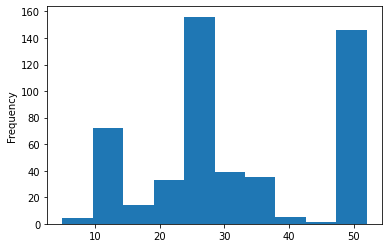

In [ ]:
mean, max, min, median, std = get_stats(df, 'Distance from Residence to Work')
print(f'mean = {mean}, max = {max}, min = {min}, median = {median}, std = {std}')
df['Distance from Residence to Work'].plot(kind='hist')

In [ ]:
df = binning(df, 'Distance from Residence to Work' , bins=[4,20,40,60], labels=['low distance', 'middle distance ','high distance' ])

BMI:

mean = 26.571363072162885, max = 38.0, min = 19.0, median = 25.0, std = 4.279202607687266


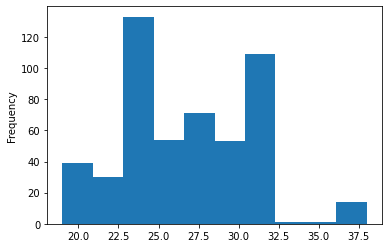

In [ ]:
mean, max, min, median, std = get_stats(df, 'Body mass index')
print(f'mean = {mean}, max = {max}, min = {min}, median = {median}, std = {std}')
df['Body mass index'].plot(kind='hist')

In [ ]:
df = binning(df, 'Body mass index' , bins=[18.5,24.9,29.9,39.9], labels=['healthy', 'overweight','obese' ])

**Converting labels to Ranks and normalizing them**

In [ ]:
def replace_string_with_number(df, column, string, number):
    df[column] = df[column].replace(string, number)
    return df

In [ ]:
df = replace_string_with_number(df,'Son', 'no child',0)
df = replace_string_with_number(df,'Son', 'low child',0.5)
df = replace_string_with_number(df,'Son', 'high child',1)

df = replace_string_with_number(df,'Age', 'low age',0)
df = replace_string_with_number(df,'Age', 'middle age ',0.5)
df = replace_string_with_number(df,'Age', 'high age',1)

df = replace_string_with_number(df,'Distance from Residence to Work', 'low distance',0)
df = replace_string_with_number(df,'Distance from Residence to Work', 'middle distance ',0.5)
df = replace_string_with_number(df,'Distance from Residence to Work', 'high distance',1)

df = replace_string_with_number(df,'Body mass index', 'healthy',0)
df = replace_string_with_number(df,'Body mass index', 'overweight',0.5)
df = replace_string_with_number(df,'Body mass index', 'obese',1)

# Data Reduction

**Removing ID**

In [ ]:
df.drop('ID', axis=1, inplace=True)

**Attribute Subset Selection**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def get_irrelevant_attributes(df,target):
    X = df.drop(target,axis=1)
    y = df[target]
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X,y)
    feature_importance = clf.feature_importances_
    feature_importance_df = pd.DataFrame(feature_importance,index=X.columns,columns=['importance']).sort_values('importance',ascending=False)
    irrelevant_attributes = feature_importance_df[feature_importance_df['importance']==0].index.tolist()
    return irrelevant_attributes

get_irrelevant_attributes(df,'Absenteeism time in hours')

['Disciplinary failure']

In [ ]:
df.drop('Disciplinary failure', axis=1, inplace=True)

**Splitting Dataframe**

In [ ]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

In [ ]:
def apply_pca(df, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(df)
    pca_df = pd.DataFrame(pca.transform(df))
    return pca_df

pf = apply_pca(X, 7)

# Data Transformation

**Normalizing numerical columns**

In [ ]:
def normalize_columns(df, columns):
    """
    Normalize specific columns in a dataframe
    """
    for column in columns :
        if column in df.columns.values.tolist():
          df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

pf = normalize(pf)

# Data Mining Alghorithms

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

# K means

In [ ]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
kmeans.fit(pf)

KMeans(init='random', n_clusters=3, random_state=42)

**choose the Appropriate Number of Clusters in k-means alghorithm.**

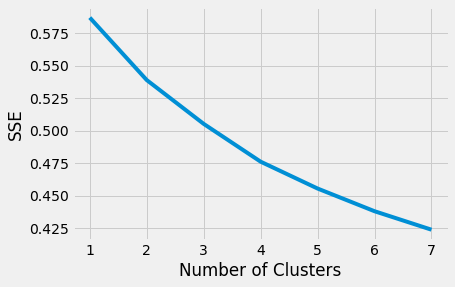

In [ ]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}
sse = []
k_max = 8
for k in range(1, k_max):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pf)
  sse.append(sum(np.min(pairwise_distances(pf, kmeans.cluster_centers_, metric='euclidean'),axis=1)) / pf.shape[0])

plt.style.use("fivethirtyeight")
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

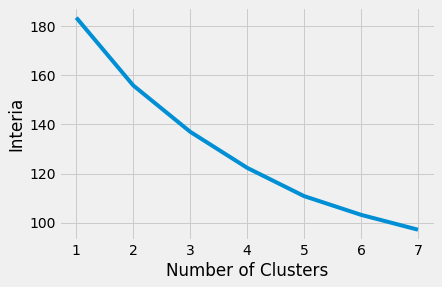

In [ ]:
sse=[]
for k in range(1, k_max):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pf)
  sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("Interia")
plt.show()

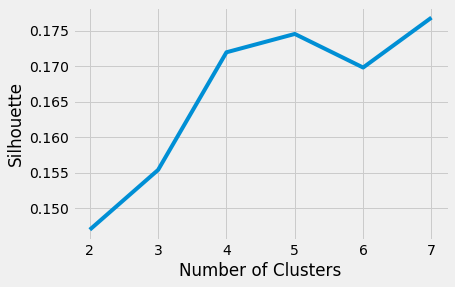

In [ ]:
sse=[]
for k in range(2, k_max):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pf)
  sse.append(silhouette_score(pf, kmeans.labels_))

plt.style.use("fivethirtyeight")
plt.plot(range(2, k_max), sse)
plt.xticks(range(2, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette")
plt.show()

**The best Value is : 2 or 5**

# K mediods

In [ ]:
!pip install scikit-learn-extra

In [ ]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(init="random",n_clusters=5,max_iter=300,random_state=42).fit(pf)

# Visualization

**KMEANS**

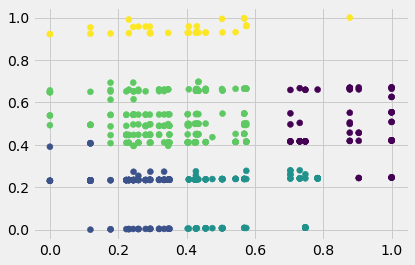

In [ ]:
pf_2D = normalize(apply_pca(X, 2))
kmeans = KMeans(init="random",n_clusters=5,n_init=10,max_iter=300,random_state=42)
kmeans.fit(pf_2D)
labels_kmeans = kmeans.predict(pf_2D)
plt.scatter(pf_2D[0], pf_2D[1], c=labels_kmeans, cmap='viridis')

**KMediods**

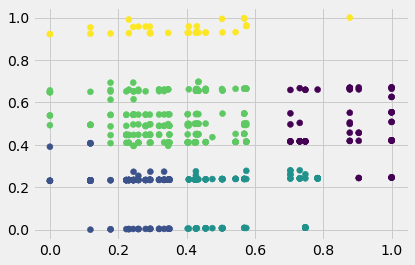

In [ ]:
pf_2D = normalize(apply_pca(X, 2))
kmedoids = KMedoids(init="random",n_clusters=5,max_iter=300,random_state=42)
kmedoids.fit(pf_2D)
labels_kmedoids = kmeans.predict(pf_2D)
plt.scatter(pf_2D[0], pf_2D[1], c=labels_kmeans, cmap='viridis')

**UMAP**

In [ ]:
!pip install umap-learn

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


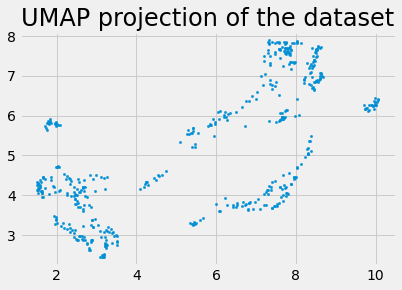

In [ ]:
import umap
def umap_visualize(df, n_neighbors=15, min_dist=0.1, n_components=8, metric='euclidean'):
    """
    Apply UMAP on a dataframe and visualize the result
    """
    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        n_components=n_components,
                        metric=metric)
    embedding = reducer.fit_transform(df)
    
    # Visualize the result
    plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the dataset', fontsize=24);
    
    return embedding

# Apply UMAP on the dataframe
embedding = umap_visualize(pf)

**Guassian mixture**

Text(0.5, 0, 'n_components')

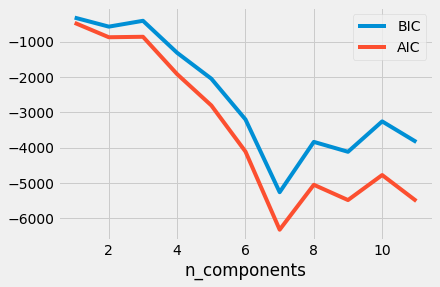

In [ ]:
from sklearn.mixture import GaussianMixture
def cluster_data(df, n_clusters):
    """
    Cluster a dataframe using Gaussian Mixture model
    """
    # Create a Gaussian Mixture model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    # Fit the model to the data
    gmm.fit(df)
    # Predict the labels
    labels = gmm.predict(df)
    # Return the labels
    return labels

n_components = np.arange(1, 12)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pf) for n in n_components]
plt.plot(n_components, [m.bic(pf) for m in models], label='BIC')
plt.plot(n_components, [m.aic(pf) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

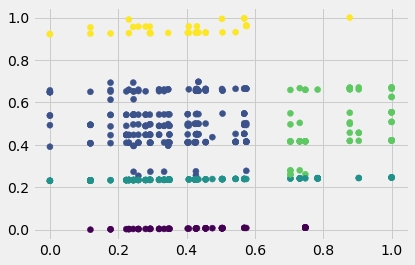

In [ ]:
labels = cluster_data(pf_2D, 5)
plt.scatter(pf_2D[0], pf_2D[1], c=labels, cmap='viridis')

**DBSCAN**

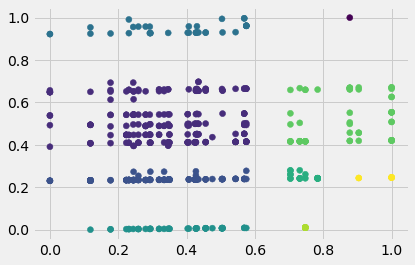

In [ ]:
from sklearn.cluster import DBSCAN
def dbscan_cluster(df, eps, min_samples):
    
    # Create a DBSCAN cluster
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
    
    # Extract cluster labels
    labels = db.labels_
    
    return labels

labels = dbscan_cluster(pf_2D,0.12,3)
plt.scatter(pf_2D[0], pf_2D[1], c=labels, cmap='viridis')

# Accuracy

**Labeling Target Data**

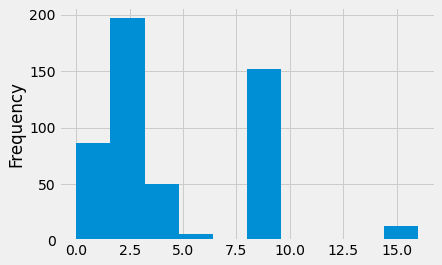

In [ ]:
Y.plot(kind='hist')

# Display the plot
plt.show()

In [ ]:
Y = Y.apply(lambda x: 0 if x <= 6  else x)
Y = Y.apply(lambda x: 1 if x > 6 and x <= 12.5 else x)
Y = Y.apply(lambda x: 2 if x > 12.5 else x)

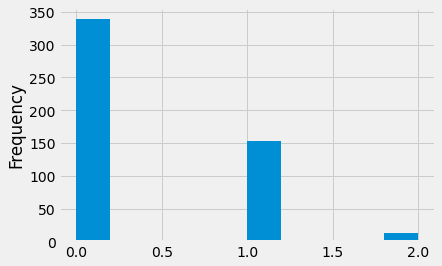

In [ ]:
Y.plot(kind='hist')
plt.show()

# Exterinsic

In [ ]:
def find_indexes(lst, value):
    """
    Finds the indexes of a value in a list.
    """
    return [i for i, x in enumerate(lst) if x == value]

def replace_values(list, old_value, new_value):
    for i in range(len(list)):
        if list[i] == old_value:
            list[i] = new_value
    return list

def find_and_replace(Y, label_list):
  for cluster_label in list(set(label_list)):
    indexes        = find_indexes(label_list, cluster_label)
    majority_label = Y.iloc[indexes].mode()
    label_list     = replace_values(label_list, cluster_label, majority_label)
  return label_list

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

predicted_kmeans   = find_and_replace(Y, labels_kmeans)
predicted_kmediods = find_and_replace(Y, labels_kmedoids)

print(f'The extrinsic accuracy of kmeans model is : {accuracy_metric(Y.values.tolist(),predicted_kmeans)}')
print(f'The extrinsic accuracy of kmediods model is : {accuracy_metric(Y.values.tolist(),predicted_kmediods)}')


The extrinsic accuracy of kmeans model is : 69.5049504950495
The extrinsic accuracy of kmediods model is : 69.5049504950495


# Intrinsic

In [ ]:
print(f'The Intrinsic accuracy of kmeans model is :{silhouette_score(pf, kmeans.labels_)}')
print(f'The Intrinsic accuracy of kmediods model is :{silhouette_score(pf, kmedoids.labels_)}')

The Intrinsic accuracy of kmeans model is :0.09387810317490074
The Intrinsic accuracy of kmediods model is :0.06565850415254955
